In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

In [5]:
def compute_r_table(template_edges):
    rows, cols = template_edges.shape
    r_table = {}
    yc = rows / 2
    xc = cols / 2
    for y in range(rows):
        for x in range(cols):
            if template_edges[y, x] > 0: 
                dx = x - xc
                dy = y - yc
                angle = math.atan2(dy, dx)
                # r = math.hypot(dx, dy) # sqrt(x*x + y*y)
                angle = math.degrees(angle) # converts an angle from radians to degrees.
                if angle not in r_table:
                    r_table[angle] = []
                r_table[angle].append([dx, dy])
    return r_table
def generalized_hough_transform(reference, template):
    """
    實現廣義 Hough 轉換算法,檢測圖像中的目標形狀。
    """
    # 1. 邊緣檢測
    template_edges = cv2.Canny(template, 50, 150)
    r_table = compute_r_table(template_edges)

    # 2. 在參考圖像上進行邊緣檢測
    reference_edges = cv2.Canny(reference, 50, 150)
    rows, cols = reference_edges.shape

    # 3. 創建一個累加器陣列
    step = 360 # 角度的累加速度
    accumulator = np.zeros((rows, cols, 360// step), dtype=np.int32)

    # 4. 對參考圖像中的邊緣點進行投票
    for y in range(rows):
        for x in range(cols):
            if reference_edges[y, x] == 255:  # 邊緣點
                # 根據 R-table 投票
                for phi, vectors in r_table.items():
                    for v in vectors:
                        for theta_idx, theta in enumerate(range(0, 360, step)):
                            theta = np.deg2rad(theta)
                            dx = v[0]
                            dy = v[1]
                            xc = int(x - dx * np.cos(theta) + dy * np.sin(theta))
                            yc = int(y - dx * np.sin(theta) - dy * np.cos(theta))
                            # 確保投票在圖像範圍內
                            if 0 <= xc < cols and 0 <= yc < rows:
                                accumulator[yc, xc, theta_idx] += 1

    return accumulator 

In [16]:
def display_result(image, accumulator, angle_step=1, box_size=(50, 50), ref='', tmp=''):
    # 找到得票數最多的候選位置
    x, y, angle_idx = np.unravel_index(np.argmax(accumulator), accumulator.shape)
    angle = angle_idx * angle_step
    
    # 將圖片轉換為 0~255 的範圍
    result_image = np.clip(image, 0, 255).astype(np.uint8)

    # 顯示結果圖片
    fig, ax = plt.subplots()
    ax.imshow(result_image, cmap="gray")

    # 繪製中心點
    ax.scatter(y, x, c='red', s=20, label=f"Center (x={y}, y={x}, angle={angle}°)")

    # 繪製方框
    box_height, box_width = box_size
    top_left_x = y - box_width // 2
    top_left_y = x - box_height // 2
    rect = patches.Rectangle(
        (top_left_x, top_left_y),  
        box_width,                
        box_height,
        linewidth=1,
        edgecolor='yellow',
        facecolor='none'
    )
    ax.add_patch(rect)

    ax.legend(loc='upper right', fontsize=12)
    ax.set_title(f"{ref}, {tmp}, angle_step={angle_step}", fontsize=16)
    ax.axis("off")
    # plt.savefig(f'result/{ref}, {tmp}.png')
    plt.show()

In [18]:
def main():
    reference = cv2.imread('img/Refernce.png', cv2.IMREAD_GRAYSCALE)
    template = cv2.imread('img/Template.png', cv2.IMREAD_GRAYSCALE)
    
    accumulator = generalized_hough_transform(reference, template)
    display_result(reference, accumulator, angle_step=360, box_size=(50, 50), ref='img/Refernce.png', tmp='img/Template.png')
    # cv2.imwrite('hw3_result/test.png', result)

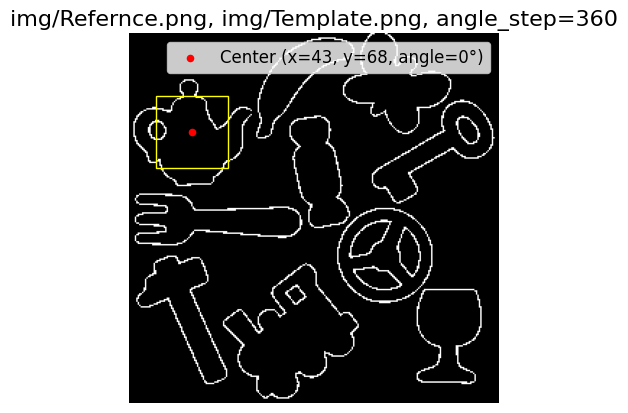

In [19]:
if __name__ == '__main__':
    main()